In [1]:
# %matplotlib qt
# %matplotlib ipympl

In [2]:
print("Importing...")
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import cv2
import easyocr

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.widgets import  Slider

Importing...


In [10]:
VIDEO_PATH =\
"Videos/Full_font1.avi"
if VIDEO_PATH is None:
    input_path =''
    while input_path == '':
        input_path = input(
            f"Input video path: ")
    VIDEO_PATH = input_path

In [11]:
CAP = cv2.VideoCapture(VIDEO_PATH)
FPS = int(CAP.get(cv2.CAP_PROP_FPS))
LENTH = int(CAP.get(cv2.CAP_PROP_FRAME_COUNT) / FPS)
CAP.set(cv2.CAP_PROP_POS_FRAMES, 0)
_, START_FRAME = CAP.read()

Configurate image processing


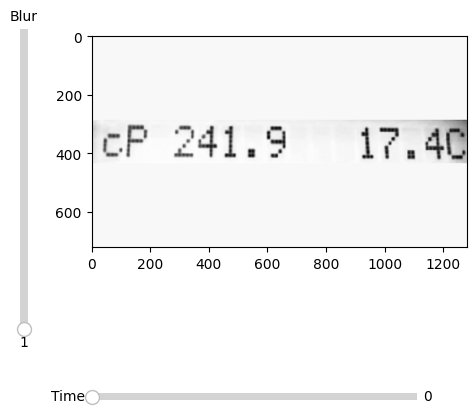

In [12]:
# Preprocess
def image_process(frame, blur=1):
    frame = cv2.blur(frame, (BLUR, BLUR))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.bitwise_not(frame)
    return frame


BLUR = 1

fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
fig.subplots_adjust(left=0.25, right=1, bottom=0.25, top=1, hspace=0, wspace=0)

PLOT = ax.imshow(image_process(START_FRAME), cmap='binary')

ax_time_slider = fig.add_axes([0.25, 0.1, 0.65, 0.03])
TIME_slider = Slider(
    ax=ax_time_slider,
    label='Time',
    valmin=0,
    valmax=LENTH,
    valinit=0,
    valstep=1,
)

ax_blur_slider = fig.add_axes([0.1, 0.25, 0.03, 0.6])
BLUR_slider = Slider(
    ax=ax_blur_slider,
    orientation='vertical',
    label='Blur',
    valmin=BLUR,
    valmax=20,
    valinit=1,
    valstep=1,
)


def update(val):
    time = TIME_slider.val
    global BLUR
    BLUR = BLUR_slider.val

    CAP.set(cv2.CAP_PROP_POS_FRAMES, int(FPS * time))
    _, frame = CAP.read()
    frame = image_process(frame, blur=BLUR)

    PLOT.set_data(frame)
    PLOT.autoscale()

    fig.canvas.draw_idle()


TIME_slider.on_changed(update)
BLUR_slider.on_changed(update)
print('Configurate image processing')
plt.show()

In [13]:
# input('Continue to selection?')
print(f'Blur value= {BLUR}')

Blur value= 1


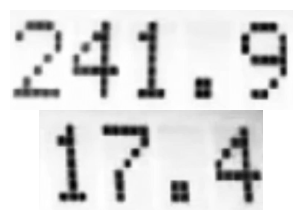

In [14]:
# Selection
def strict(image, x, y, w, h):
    return image[y:y + h, x:x + w]


SLICE_CORDS = []
values_to_recognize = int(input('Values to recognize: '))

for i in range(values_to_recognize):
    roi_frame = image_process(START_FRAME, blur=BLUR)
    roi_frame = cv2.bitwise_not(roi_frame)
    current_slice = cv2.selectROI(
        f'Select {len(SLICE_CORDS)+1}',
        roi_frame,
        fromCenter=False,
        showCrosshair=True,
    )
    SLICE_CORDS.append(current_slice)
cv2.destroyAllWindows()

fig, axes = plt.subplots(nrows=values_to_recognize)
if not isinstance(axes, np.ndarray): axes = [axes]
fig.set_size_inches(3, 1 * values_to_recognize)
fig.subplots_adjust(left=0, right=1, bottom=0.0, top=1, hspace=0, wspace=0)
start_slices = [
    strict(image_process(START_FRAME, blur=BLUR), *params)
    for params in SLICE_CORDS
]
for i in range(values_to_recognize):
    axes[i].set_axis_off()
    axes[i].imshow(start_slices[i], cmap='binary')
plt.show()

In [15]:
# Recognize
def correct(values):
    return values


print('Starting recognizer...')
reader = easyocr.Reader(['en'])

input_fps = input('Input number of frames per second: ')
try:
    read_fps = int(input_fps)
except:
    read_fps = 1

print('Recognizing:')
diap = tqdm(iterable=range(0, FPS * LENTH, int(FPS / read_fps)))

data = []
for i_frame in diap:
    CAP.set(cv2.CAP_PROP_POS_FRAMES, i_frame)
    _, frame = CAP.read()
    i_text = []
    for select_window in SLICE_CORDS:
        selection = strict(frame, *select_window)
        process_confs = dict(blur=BLUR)
        selection = image_process(selection,**process_confs )
        raw_values = [
            (value, round(confidence,3)) for _, value, confidence
            in reader.readtext(selection)
            ] #yapf:disable
        
        values = correct(raw_values)
        
        i_text.append(values)

    data.append(i_text)

Starting recognizer...
Recognizing:


100%|██████████| 56/56 [00:16<00:00,  3.36it/s]


In [ ]:
def correct(value):
    return value

In [21]:
raw_value = data[0][0]

In [26]:
raw_value

[('241', 0.999), ('9', 1.0)]

In [34]:
class ValueCorrector:

    def __init__(
        self,
        raw_value,
        reader,
        process_func,
    ):
        self.parts = len(raw_value)
        self.values = [value for value, confidence in raw_value]

    def correct(self):
        if self.parts == 1:
            try:
                result = float(self.values[0])
                self._value_check
            except ValueError:
                pass
        self._process

    def _value_check(self):
        ...

    def _combine(self):

        if self.parts == 2:
            raw_result = '.'.join(self.values)

        elif self.parts == 3:
            raw_result = f'{self.values[0]}.{self.values[2]}'

        try:
            result = float(raw_result)
        except:
            print('error', raw_result)
            result = None
        return result

    @staticmethod
    def _process(image, ):
        ...


In [37]:
a= ValueCorrector(raw_value)
a._combine()

241.9